# Particle or Photon Orbits near a Black Hole

## Theory

A particle or photon in the Schwarzschild solution to the Einsten field equations, has the Lagrangian:
\begin{equation}
    L = F(r)\dot{t^{2}} - \frac{\dot{r}^{2}}{F(r)} - (r \dot{\phi^{2}}) =
    \begin{cases}
		c^2 & \text{if particle is massive [set $c=1$]}\\
		0 & \text{if particle is massless}
	\end{cases}
\end{equation}

where $F(r) = 1 - 1/r$ and dots denote differentiation with respect to an affine parameter along the geodesic.
Units are such that $c = 1$ and $2GM = 1$ so Schwarzschild radius $r = 1$.

By applying Lagrange's equations to variables $t, r, \phi$, the equations of motion and/or conserved quantities can be deduced.
This gives us:

\begin{equation}
	F(r)\dot{t} = k
\end{equation}

\begin{equation}
	r^2\dot{\phi} = h
\end{equation}

\begin{equation}
	\frac{\ddot{r}}{F(r)}+\frac{1}{2}F'(r)\dot{t}^2-\frac{1}{2}\frac{F'(r)}{F(r)^2}\dot{r}^2-r\dot{\phi}^2 = 0
\end{equation}

for $t, r, \phi$, 2 conserved quantities and an equation of motion respectively. 

By substituting the conserved quantities found into the equation of motion, expressing $r$ as a function of $\phi$. 
Additionally, performing change of variables $u \equiv 1/r$ yields and equation allowing orbit shape to be determined.

For massive particles:

\begin{equation}
	\dot{r}^2 - \frac{1}{r} + \frac{h^2}{r^2} \bigg(1 - \frac{1}{r} \bigg) = k^2 - 1
\end{equation}

\begin{equation}
	\frac{d^2u}{d\phi^2}+u-\frac{3}{2}u^2=\frac{1}{2h^2}
\end{equation}

For massless particles:

\begin{equation}
	\dot{r}^2 + \frac{h^2}{r^2} \bigg(1 - \frac{1}{r} \bigg) = k^2
\end{equation}

\begin{equation}
	\frac{d^2u}{d\phi^2}+u-\frac{3}{2}u^2=0
\end{equation}

## Aim

In this notebook, I aim to create tools to allow the user to explore properties of such orbits and their limiting behaviours using numerical methods and visualisations in cells.

This work builds on the project work done for my 2021-22 CATAM project which was originally coded in MATLAB.
Instead of handwriting a numerical integration script as I did before, I will be using numerical integration routines from the SciPy library.

In [1]:
import numpy as np
from scipy.integrate import odeint, complex_ode
import matplotlib.pyplot as plt
import cmath

# Particle orbits

## Variables

- r0 = Initial radial distance from black hole
- dr_dphi0 = Initial rate of change of radial distance with respect to angle
- h = Specific angular momentum of particle
- P = Number of radians to explore over

In [15]:
def h_circ_massive(r):
    assert ((r * (2 - 3 / r) ** (-1)) >= 0), "Invalid value for r"
    return np.sqrt(r * (2 - 3 / r) ** (-1))

In [2]:
def EoM_massive(U, P, h):
    assert (h != 0), "Invalid value for h"
    u, du_dphi = U
    dU_dphi = [du_dphi, 3 / 2 * u ** 2 - u + 1 / (2 * h ** 2)]
    return dU_dphi

In [3]:
def propTime_massive(Tau, r, h, k):
#    assert ((k ** 2 - 1 + 1 / r - (h / r) ** 2 * (1 - 1 / r)) >= 0), "Negative"
    # need cmath as term inside sqrt < 0 at some points
    # without cmath, can't integrate for real part using odeint
    dtau_dr = 1 / cmath.sqrt(k ** 2 - 1 + 1 / r - (h / r) ** 2 * (1 - 1 / r))
    return dtau_dr.real

## Orbit trajectory

### Motivation

Aim to plot the trajectories of particle orbits about a black hole.

Theory states if there is no angular momentum $(h)$ (i.e. no angular movement), then particle must radially in-fall to the centre of the black hole.

Would expect to observe some type of spiral in-fall as angular momentum increases.
Come to expect that there should be a specific angular momentum $h_c$ at which circular orbit occurs.

Can determine this by solving equation of motion

$$\dot{r}^2 + V_{eff} = k^2 - 1 $$

for maximum/minimum value of $V_{eff}$ (i.e. $dV_{eff}/dr = 0$).
This gives

$$h_c^2 = r\bigg(2 - \frac{3}{r}\bigg)^{-1}$$

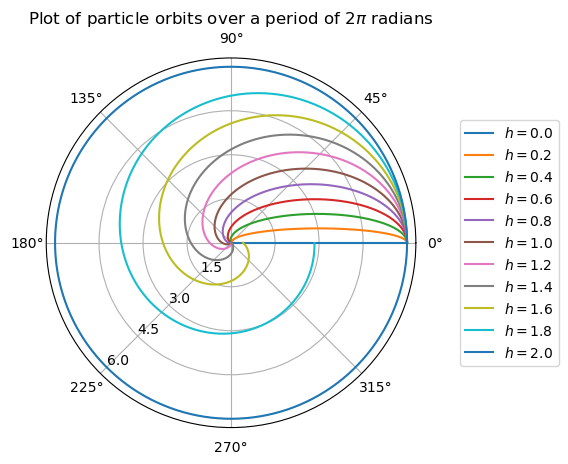

In [19]:
r0 = 6
h_circ = h_circ_massive(r0)
dr_dphi0 = 0
h = np.linspace(0, h_circ, 11)
P = 2 * np.pi
dphi = 0.01

phi = np.arange(0, P, dphi) # Angles to be plotted over in radians
u0 = [1 / r0, -dr_dphi0 / (r0 ** 2)] # Initial conditions for integration

fig1, ax1 = plt.subplots(subplot_kw = {'projection': 'polar'})

for i in range(len(h)):
    if h[i] != 0:
        
        sol = odeint(EoM_massive, u0, phi, args=(h[i],))
        # Can ignore error message 'Excess work done on this call (perhaps wrong Dfun type)'
        # Ignorable as will filter out results affected by numerical errors here
        # Error determined by considering largest expected change given the change in angle
        # Imagine particle reaches Schwarzschild radius (r = u = 1) and is immediately sucked into centre
        # Suggests any change bigger than 1 / dphi is probably inaccurate
        du = np.diff(sol[:, 0])
        anomalies = np.where(abs(du) >= 1 / dphi)[0]
        
        if len(anomalies):
            u_corr = sol[:, 0][: anomalies[0] + 1]
        else:
            u_corr = sol[:, 0]
        r = np.divide(1, u_corr)
        ax1.plot(phi[:len(r)], r, label = r'$h = %.1f$' % h[i])
    else: # Radial geodesic
        # Radial infall occurs as there is no angular momentum
        r = np.linspace(r0, 0, 100)
        ax1.plot(np.zeros(len(r)), r, label = r'$h = %.1f$' % h[i])

R = r0 * 1.05
r_labels = [r0 / 4, r0 / 2, r0 * 3 / 4, r0]
#phi_labels = ['0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$',r'$\frac{5\pi}{4}$', r'$\frac{3\pi}{2}$', r'$\frac{7\pi}{4}$']
ax1.set_rmax(R)
ax1.set_rticks(r_labels)

#ax.set_xticks(phi_labels)

ax1.grid(True)
ax1.set_rlabel_position(225)
ax1.legend(loc = 'center left', bbox_to_anchor = (1.1, 0.5))

ax1.set_title(r"Plot of particle orbits over a period of $2\pi$ radians")
plt.show()

### Interpretation

- (h = 0) Radial in-fall occurs when particle has no angular momentum.
- (0 < h < 1.8 ) Spiral in-fall until particle captured by black hole (passes Schwarzschild radius)
- (h = 2) Circular orbit about black hole


## Time taken to in-fall

Rearrange formula describing angular momentum to obtain an estimate for proper time elapsed per step of integration.

$$d\tau = \frac{dr}{\sqrt{k^2 - 1 + r^{-1} - h^{2} r^{-2} (1-r^{-1})}}$$

Integrate $r$ from $r_0$ to $0$ to estimate time taken for particle to in-fall.

In [5]:
h = np.linspace(0, 1.7, 18)
r0 = 6
dr_dtau0 = 0
dr = 0.01
r = np.arange(r0, 0, -dr)
tau0 = 0 # Initial conditions for integration
tau = np.zeros(len(h))

for i in range(len(h)):
    k = np.sqrt(1 + (dr_dtau0) ** 2 - 1 / r0 + (h[i] / r0) ** 2 * (1 - 1 / r0))
    sol = odeint(propTime_massive, tau0, r[::-1], args=(h[i], k))
    # Filter out nan values
    anomalies = np.where(sol[:, 0] == float("nan"))[0]
    if len(anomalies):
        tau[i] = sol[:, 0][anomalies[0] + 1] #change this index to an actual num value
    else:
        tau[i] = sol[:, 0][-1]

print('h', 'Proper time taken to reach r = 0', sep='\t\t')
for j in range(len(tau)):
    print("%.1f" %h[j], "%.4f" %tau[j], sep='\t\t')


h		Proper time taken to reach r = 0
0.0		23.0853
0.1		23.0919
0.2		23.1518
0.3		23.2749
0.4		23.4664
0.5		23.7327
0.6		24.0820
0.7		24.5258
0.8		25.0800
0.9		25.7662
1.0		26.6153
1.1		27.6716
1.2		29.0017
1.3		30.7108
1.4		32.9762
1.5		36.1289
1.6		40.8946
1.7		49.4638


# Exploring precession

### Motivation

See in previous plot that for $r0 = 6$, $(dr/d\phi)_0 = 0$, $h = 1.8$ hasn't fully in-spiralled.

Verify if whether it does so by simply plotting for a longer time period.

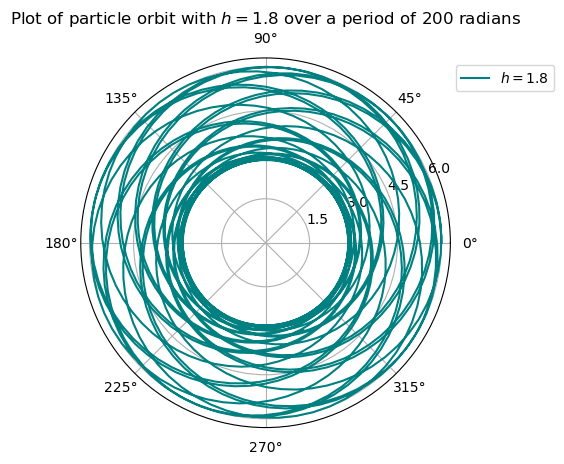

In [173]:
r0 = 6
dr_dphi0 = 0
h = 1.8
P = 200
dphi = 0.1

phi = np.arange(0, P, dphi) # Angles to be plotted over in radians
u0 = [1 / r0, -dr_dphi0 / (r0 ** 2)] # Initial conditions for integration

if h != 0:
    sol = odeint(EoM_massive, u0, phi, args=(h,))
    # Filter out results affected by numerical errors
    # Error determined by considering largest expected change given the change in angle
    # Imagine particle reaches Schwarzschild radius (r = u = 1) and is immediately sucked into centre
    # Suggests any change bigger than 1 / dphi is probably inaccurate
    du = np.diff(sol[:, 0])
    anomalies = np.where(abs(du) >= 1 / dphi)[0]
    if len(anomalies):
        u_corr = sol[:, 0][: anomalies[0] + 1]
        print(sol[:, 0][anomalies[0] - 1:anomalies[0] + 3])
    else:
        u_corr = sol[:, 0]
    r = np.divide(1, u_corr)
else: # Radial geodesic
    # Radial infall occurs as there is no angular momentum
    r = np.linspace(r0, 0, 100)
    phi = np.zeros(100)
    
fig2, ax2 = plt.subplots(subplot_kw = {'projection': 'polar'})

ax2.plot(phi[:len(r)], r, color = 'teal', label = r'$h = %.1f$' %h)

R = max(r) * 1.05
r_labels = [r0 / 4, r0 / 2, r0 * 3 / 4, r0]
#phi_labels = ['0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$',r'$\frac{5\pi}{4}$', r'$\frac{3\pi}{2}$', r'$\frac{7\pi}{4}$']

ax2.set_rmax(R)
ax2.set_rticks(r_labels)
#ax.set_xticks(phi_labels)

ax2.grid(True)
ax2.legend(loc = 'upper right', bbox_to_anchor = (1.3, 1.0))

ax2.set_title(r"Plot of particle orbit with $h=%.1f$ over a period of %i radians" %(h, P))
plt.show()

### Interpretation

Initially cautious of numerical error so tried reducing the step-size for more accurate numerical integration results but obtained the same result.

Assuming this is correct, it then suggests for certain values of angular momentum, particle orbit precesses around black hole.

## Effective potential ($V_{eff}$) of an orbit

## Motivation

Given some initial conditions for $r$ and $dr/d\phi$, compare kinetic energy $(\dot{r}^2)$ to the effective potential $(V_{eff})$ experienced by the particle, and determine thresholds at which we expect particles to have bound or unbound orbits.

$$V_{eff} = -\frac{1}{r} + \frac{h^2}{r^2}\bigg(1 - \frac{1}{r}\bigg)$$

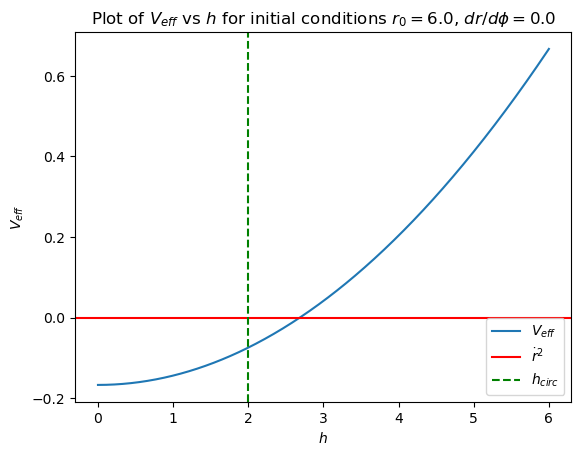

In [39]:
r0 = 6
dr_dtau0 = 0
h = np.linspace(0, r0, r0 * 100 + 1)
h_circ = h_circ_massive(r0)

def V_eff(h, r0, dr_dtau0):
    assert (r0 > 0), "Invalid initial radius"
    return - 1 / r0 + (h / r0) ** 2 * (1 - 1 / r0)

fig = plt.figure()
plt.plot(h, V_eff(h, r0, dr_dtau0), label = r"$V_{eff}$")
plt.axhline(dr_dtau0 ** 2, color = 'r', label = r"$\dot{r}^2$")
plt.axvline(h_circ, ls = '--', color = 'g', label = r"$h_{circ}$")
plt.legend(loc = "lower right")
plt.xlabel(r"$h$")
plt.ylabel(r"$V_{eff}$")
plt.title(r"Plot of $V_{eff}$ vs $h$ for initial conditions $r_0 = %.1f$, $dr/d\phi = %.1f$" %(r0, dr_dphi0))


plt.show()

### Interpretation

- $(V_{eff} < \dot{r}^2)$: Unbound hyperbolic orbits
- $(V_{eff} = \dot{r}^2)$: Bound parabolic orbit
- $(V_{eff} > \dot{r}^2)$: Bound orbits

## Circular orbit radii

### Motivation

Given the existence of circular orbits at the extrema of $V_{eff}$, it should be possible to plot the radii at which they exist for different $h$.

Find that circular orbits for given $h$ are at radii:

$$r_\pm = h(h \pm \sqrt{h^2 - 3})$$

with their stability indicated by

$$\frac{d^2 V_{eff}}{dr^2}\biggr\rvert_r\pm = \frac{2 h^2}{r^5_\pm}(r_\pm - 3)$$

### Possible circular orbits

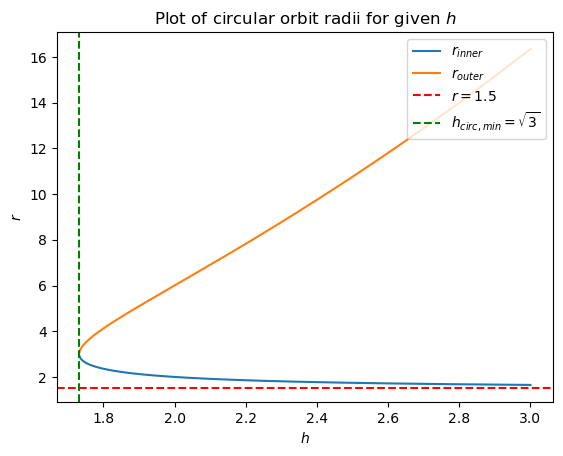

In [81]:
# rounded sqrt(3) to 3 d.p. up to avoid invalid sqrt value error messages
h = np.linspace(1.733, 3, 3001) 

def r_in(h):
    return h * (h - np.sqrt(h ** 2 - 3))
    
def r_out(h):
    return h * (h + np.sqrt(h ** 2 - 3))

fig = plt.figure()
plt.plot(h, r_in(h), label = r"$r_{inner}$")
plt.plot(h, r_out(h), label = r"$r_{outer}$")
plt.axhline(1.5, ls = '--', color = 'r', label = r"$r = 1.5$")
plt.axvline(np.sqrt(3), ls = '--', color = 'g', label = r"$h_{circ, min} = \sqrt{3}$")
plt.legend(loc = "upper right")
plt.xlabel(r"$h$")
plt.ylabel(r"$r$")
plt.title(r"Plot of circular orbit radii for given $h$")

plt.show()

### Circular orbit stability

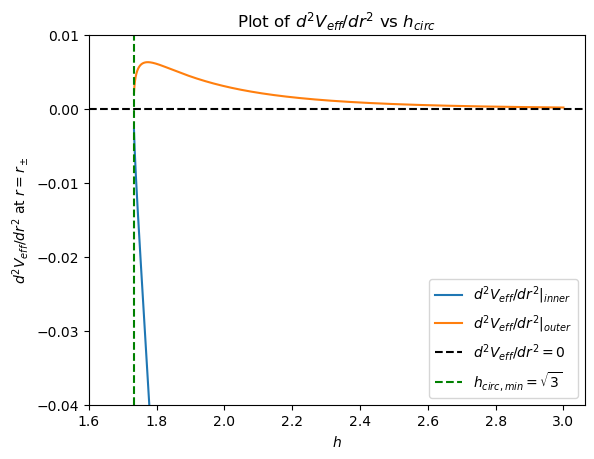

In [104]:
h = np.linspace(1.733, 3, 3001) 

def r_in(h):
    return h * (h - np.sqrt(h ** 2 - 3))

def d2V_dr2_in(h):
    r = r_in(h)
    return (2 * h ** 2 / r ** 5) * (r - 3)
    
def r_out(h):
    return h * (h + np.sqrt(h ** 2 - 3))

def d2V_dr2_out(h):
    r = r_out(h)
    return (2 * h ** 2 / r ** 5) * (r - 3)

fig = plt.figure()
plt.plot(h, d2V_dr2_in(h), label = r"$d^2V_{eff}/dr^2\vert_{inner}$")
plt.plot(h, d2V_dr2_out(h), label = r"$d^2V_{eff}/dr^2\vert_{outer}$")
plt.axhline(0, ls = '--', color = 'k', label = r"$d^2V_{eff}/dr^2 = 0$")
plt.axvline(np.sqrt(3), ls = '--', color = 'g', label = r"$h_{circ, min} = \sqrt{3}$")
plt.legend(loc = "lower right")
plt.xlabel(r"$h$")
plt.ylabel(r"$d^2V_{eff}/dr^2$ at $r = r_\pm$")
plt.title(r"Plot of $d^2V_{eff}/dr^2$ vs $h_{circ}$")
plt.xlim(1.6)
plt.ylim(-0.04, 0.01)

plt.show()

### Interpretation

- No circular orbits exist for $r < 1.5$, nor for $h < \sqrt{3}$
- Inner circular orbits range from $r_{in} \in (1.5, \sqrt{3}]$
- Outer circular orbits range from $r_{out} \in (\sqrt{3}, \infty)$
- Inner circular orbits tend to $r = 1.5$ as $h \rightarrow \infty$
- Inner circular orbits are always unstable (i.e. any pertubation leads to particle capture by black hole)
- Outer circular orbits are stable
- Inner and outer circular orbits converge to single circular orbit at $r = 3$ as $h \rightarrow \sqrt{3}$

## Perturbed circular orbits

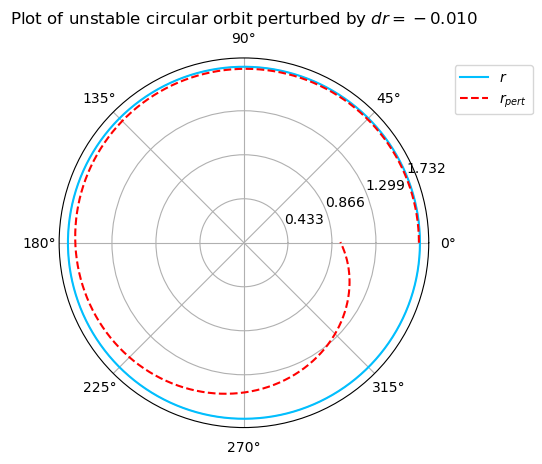

In [148]:
# See previous section for guidance on selecting r0
r0 = np.sqrt(3)
dr = -0.01 # size and direction (-ve = inwards, +ve = outwards) of pertubation
r0_pert = r0 + dr
dr_dphi0 = 0
h_circ = h_circ_massive(r0)
P = 6.3
dphi = 0.01

phi = np.arange(0, P, dphi) # Angles to be plotted over in radians
u0 = [1 / r0, -dr_dphi0 / (r0 ** 2)] # Initial conditions for integration
u0_pert = [1 / r0_pert, -dr_dphi0 / (r0_pert ** 2)]

sol = odeint(EoM_massive, u0, phi, args=(h_circ,))
sol_pert = odeint(EoM_massive, u0_pert, phi, args=(h_circ,))
# Filter out results affected by numerical errors
# Error determined by considering largest expected change given the change in angle
# Imagine particle reaches Schwarzschild radius (r = u = 1) and is immediately sucked into centre
# Suggests any change bigger than 1 / dphi is probably inaccurate
du = np.diff(sol[:, 0])
du_pert = np.diff(sol_pert[:, 0])
anomalies = np.where(abs(du) >= 1 / dphi)[0]
anomalies_pert = np.where(abs(du_pert) >= 1 / dphi)[0]
if len(anomalies):
    u_corr = sol[:, 0][: anomalies[0] + 1]
else:
    u_corr = sol[:, 0]
if len(anomalies_pert):
    u_corr_pert = sol_pert[:, 0][: anomalies_pert[0] + 1]
else:
    u_corr_pert = sol_pert[:, 0]
r = np.divide(1, u_corr)
r_pert = np.divide(1, u_corr_pert)

fig2, ax2 = plt.subplots(subplot_kw = {'projection': 'polar'})

ax2.plot(phi[:len(r)], r, color = 'deepskyblue', label = r'$r$')
ax2.plot(phi[:len(r_pert)], r_pert, ls = '--', color = 'r', label = r'$r_{pert}$')

R = max(max(r_pert), max(r)) * 1.05
r_labels = [r0 / 4, r0 / 2, r0 * 3 / 4, r0]
phi_labels = ['0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$',r'$\frac{5\pi}{4}$', r'$\frac{3\pi}{2}$', r'$\frac{7\pi}{4}$']

ax2.set_rmax(R)
ax2.set_rticks(r_labels)
#ax.set_xticks(phi_labels)
ax2.grid(True)
ax2.legend(loc = 'upper right', bbox_to_anchor = (1.3, 1.0))
if r0 <= np.sqrt(3):
    ax2.set_title(r"Plot of unstable circular orbit perturbed by $dr=%.3f$" %dr)
else:
    ax2.set_title(r"Plot of stable circular orbit perturbed by $dr=%.3f$" %dr)

plt.show()